## Install and import watson-machine-learning and other dependecies

In [1]:
!pip install -U ibm-watson-machine-learning | tail -n 1
!pip install autoai-libs | tail -n 1

### Importing the libraries

In [36]:
import os
from ibm_watson_machine_learning import APIClient
import numpy as np
import json

from pandas import DataFrame, MultiIndex
import pandas as pd
from pprint import pprint
from IPython.display import display
    
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib

### Creating a function to save the AutoAI results in a PDF file

In [46]:
# Function for saving the results to a pdf file

def fn_print_pdf(df,pp,titletext, page_x, page_y, strg, cell_h, cell_fntsz, cell_w):
    
    total_rows, total_cols = df.shape;
    
    rows_per_page = 30; # Number of rows per page
    rows_printed = 0
    page_number = 1;
    
    titletext=titletext        # Title of the page
    page_x=page_x              # Page size
    page_y=page_y              # Page size
    table_loc=strg             # pd.plotting.table location 
    cell_height=cell_h         # Cell height value
    cell_fontsize=cell_fntsz   # Cell font size
    cell_width=cell_w          # Cell font width
    
    while (total_rows >0):
        fig=plt.figure(figsize=(page_x, page_y))  # 8.5, 11
        plt.gca().axis('off')
        matplotlib_tab = pd.plotting.table(plt.gca(),df.iloc[rows_printed:rows_printed+rows_per_page], 
                                           loc=table_loc, colWidths=[0.15]*total_cols, rowLoc='right') 
        
        #Tabular styling
        
        
        # Header,Footer and Page Number
        fig.text(4.25/8.5, 10.5/11., titletext, ha='center', fontsize=14)
        pp.savefig()
        plt.show()
        plt.close()
        #Update variables
        rows_printed += rows_per_page;
        total_rows -= rows_per_page;
        page_number+=1;

## Defining WML credentials 

#### Get the training ID after running your AutoAI experiment. Once its run, go to the `Assets tab` and click on the respective "AutoAI experiment". Then click on `(i)` button as shown in the image below in order to get the information for the `Experiment details`. Under that pane, you should be able to see the training ID for the experiment.


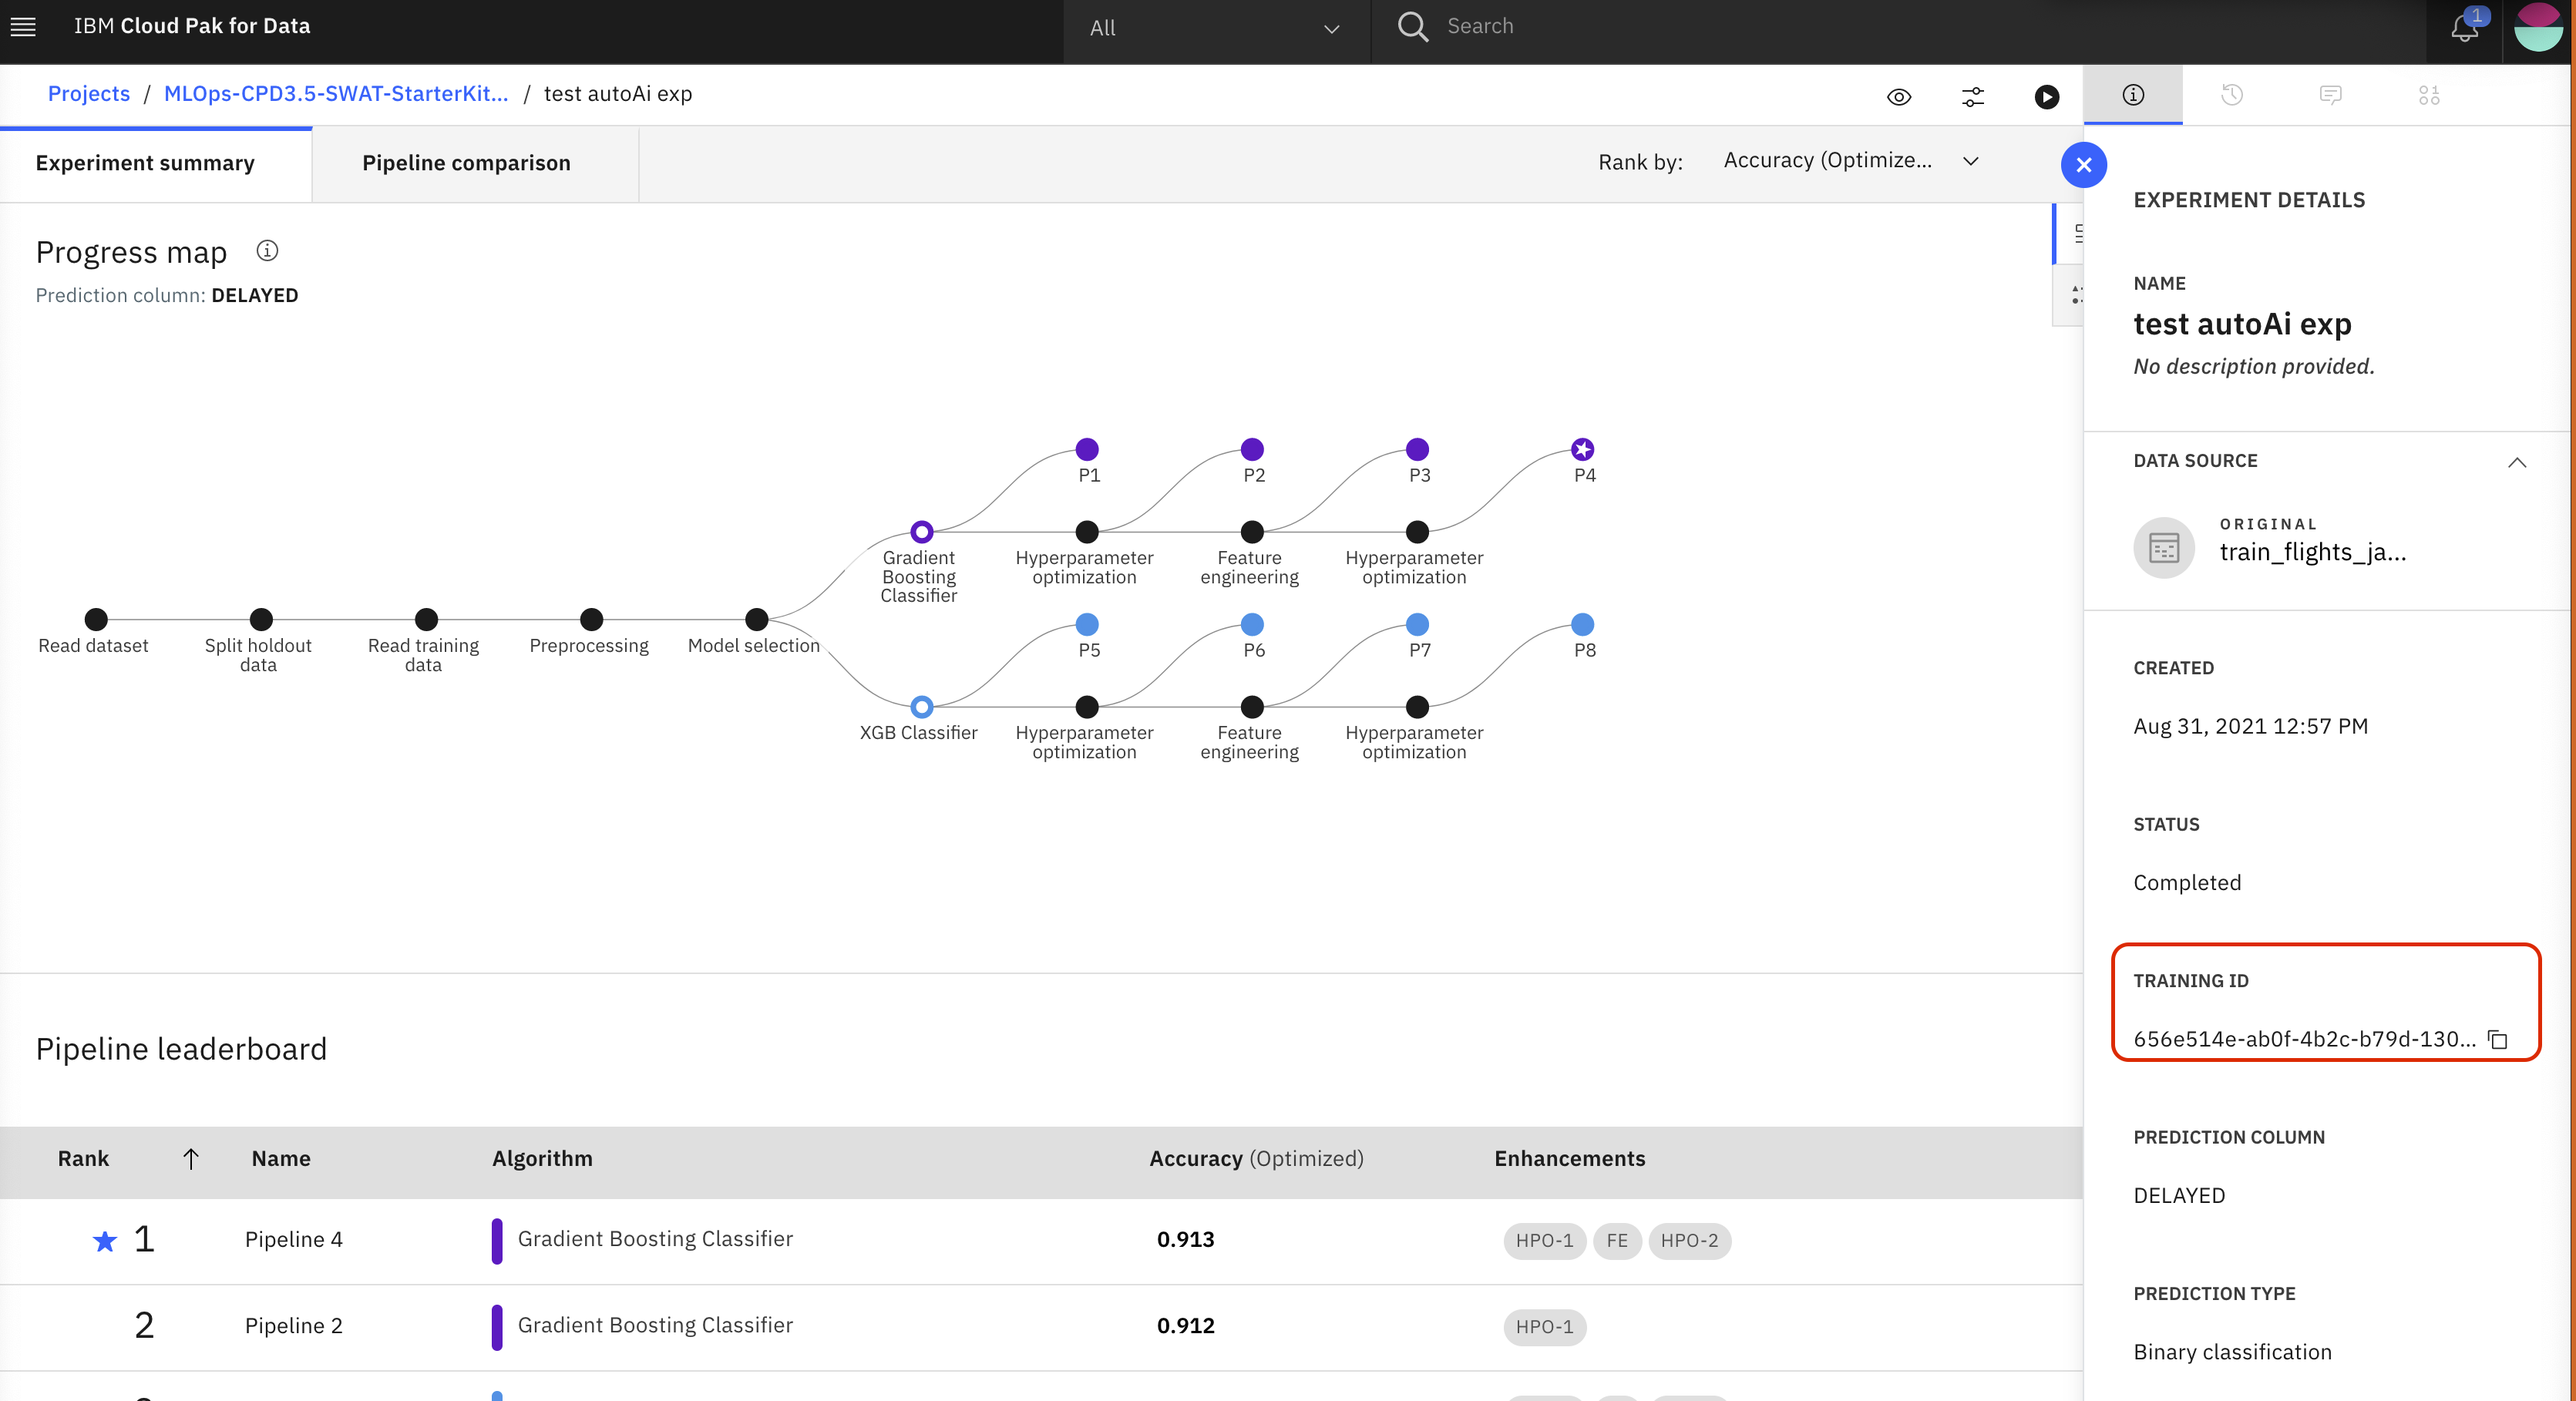

In [7]:
TRAINING_ID = '<ENTER TRAINING ID HERE>'
PROJECT_ID = os.environ['PROJECT_ID']

In [11]:
from ibm_watson_machine_learning import APIClient

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "wml_local",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "4.0"
}

client = APIClient(wml_credentials)

client.set.default_project(PROJECT_ID)

'SUCCESS'

In [12]:
client.pipelines.list()

------------------------------------  --------------------  ------------------------
ID                                    NAME                  CREATED
c646d473-a7ec-4fd6-beab-545343d27836  test autoAi exp       2021-09-01T20:54:53.002Z
70049b1b-96c5-40ff-8c25-e783c367cf2a  shikhar_AutoAI        2021-08-23T19:03:07.002Z
b57f9590-bcb6-41bd-9dc2-9ba2af6c98b1  sk-autoai-3           2021-08-23T19:03:07.002Z
8592c552-3b74-4843-bc6d-2dfaff670e27  sk-auto-ai-churn      2021-08-23T19:03:07.002Z
1efb942e-e592-426d-b2a5-8cebbf308a21  AutoAI_Complaint_exp  2021-08-23T19:03:07.002Z
ea570a41-e405-4923-9c04-dc8e7378a707  airline_autoAI_exp    2021-08-23T19:03:07.002Z
e527a12a-ce73-4fbc-8f1c-d2aa7f442af7  sk_autoAI             2021-08-23T19:03:07.002Z
62afcd20-3983-4104-818f-f00a01c9161c  Airline_AutoAI_exp    2021-08-23T19:03:07.002Z
------------------------------------  --------------------  ------------------------


## Parameters that were used in the AutoAI experiment

### Metadata

Paste the `GUID` from the above list for the Auto-AI model in the below cell.

In [19]:
guid='<Enter GUID here>'
print(json.dumps(client.pipelines.get_details(guid), indent=2))

{
  "entity": {
    "document": {
      "doc_type": "pipeline",
      "pipelines": [
        {
          "id": "autoai",
          "nodes": [
            {
              "id": "automl",
              "op": "kube",
              "parameters": {
                "input_file_separator": ",",
                "optimization": {
                  "compute_pipeline_notebooks_flag": true,
                  "daub_adaptive_subsampling_max_mem_usage": 9000000000.0,
                  "holdout_param": 0.1,
                  "label": "DELAYED",
                  "learning_type": "classification",
                  "max_num_daub_ensembles": 2.0,
                  "positive_label": 1.0,
                  "run_cognito_flag": true,
                  "scorer_for_ranking": "accuracy"
                },
                "output_logs": true,
                "stage_flag": true
              },
              "runtime_ref": "autoai",
              "type": "execution_node"
            }
          ],
          "run

### Summary from the metadata

In [20]:
print('AutoAI project name: \t\t', client.pipelines.get_details(guid)['metadata']['name'])
print('Prediction Column: \t\t', client.pipelines.get_details(guid)['entity']['document']['pipelines'][0]['nodes'][0]['parameters']['optimization']['label'])
print('Learning Type: \t\t\t', client.pipelines.get_details(guid)['entity']['document']['pipelines'][0]['nodes'][0]['parameters']['optimization']['learning_type'])
print('Optimized Metric: \t\t', client.pipelines.get_details(guid)['entity']['document']['pipelines'][0]['nodes'][0]['parameters']['optimization']['scorer_for_ranking'])
print('Holdout Paramter: \t\t', client.pipelines.get_details(guid)['entity']['document']['pipelines'][0]['nodes'][0]['parameters']['optimization']['holdout_param'])

AutoAI project name: 		 test autoAi exp
Prediction Column: 		 DELAYED
Learning Type: 			 classification
Optimized Metric: 		 accuracy
Holdout Paramter: 		 0.1


# AutoAI Results

## Model Evaluation measures for each pipeline

In [21]:
training_details = client.training.get_details(TRAINING_ID)

In [22]:
columns = (['Pipeline Name', 'Number of enhancements', 'Estimator'] + 
           [metric_name for metric_name in training_details['entity']['status'].get('metrics',[{}])[0].get('ml_metrics', {}).keys()])


values= []

iter_number= 0

for pipeline in training_details['entity']['status'].get('metrics',[]):
    if pipeline['context']['phase'] == 'global_output':
        number_of_enhancements = len(pipeline['context']['intermediate_model']['composition_steps']) -5
         
        values.append([f"Pipeline_{pipeline['context']['intermediate_model']['name'].split('P')[-1]}"] + [number_of_enhancements] + 
                      [pipeline['context']['intermediate_model']['pipeline_nodes'][-1]] +  
                      [metric_name for metric_name in training_details['entity']['status'].get('metrics', [{}])[iter_number].get('ml_metrics', {}).values()])
        iter_number = iter_number + 1

pipelines= DataFrame(data=values, columns=columns) 
pipelines.drop_duplicates(subset="Pipeline Name", keep='first', inplace=True)
pipelines.set_index('Pipeline Name', inplace=True)
pipelines.transpose()


Pipeline Name,Pipeline_1,Pipeline_2,Pipeline_3,Pipeline_4,Pipeline_5,Pipeline_6,Pipeline_7,Pipeline_8
Number of enhancements,0,1,2,3,0,1,2,3
Estimator,GradientBoostingClassifierEstimator,GradientBoostingClassifierEstimator,GradientBoostingClassifierEstimator,GradientBoostingClassifierEstimator,XGBClassifierEstimator,XGBClassifierEstimator,XGBClassifierEstimator,XGBClassifierEstimator
training_roc_auc,0.942441,0.942463,0.942834,0.941193,0.942441,0.942463,0.942834,0.941193
holdout_precision,0.894118,0.885057,0.883268,0.895582,0.894118,0.885057,0.883268,0.895582
training_average_precision,0.898683,0.899334,0.900324,0.898769,0.898683,0.899334,0.900324,0.898769
holdout_average_precision,0.907909,0.908343,0.909163,0.904724,0.907909,0.908343,0.909163,0.904724
training_neg_log_loss,-0.234793,-0.236052,-0.232284,-0.235654,-0.234793,-0.236052,-0.232284,-0.235654
holdout_recall,0.757475,0.767442,0.754153,0.740864,0.757475,0.767442,0.754153,0.740864
training_precision,0.883154,0.88362,0.882648,0.891757,0.883154,0.88362,0.882648,0.891757
holdout_accuracy,0.916597,0.916597,0.913261,0.913261,0.916597,0.916597,0.913261,0.913261


## Confusion matrix for each pipeline

In [23]:
# One way of showing the confusion matrix values is focusing on specific True Class
#   for instance True Class equals to 1
#

columns = ['Pipeline Name', 'False Negative', 'False Positive', 'True Negative', 'True Positive', 'True Class']
values = []

for n_pipeline in training_details['entity']['status'].get('metrics', []):
    if n_pipeline['context']['phase'] == 'global_output':
        data = n_pipeline['context']['binary_classification']['confusion_matrix']
        values.append([f"Pipeline_{n_pipeline['context']['intermediate_model']['name'].split('P')[-1]}"] + 
                      [value for value in data[1].values()])
        

confusion_matrix = DataFrame(data=values, columns=columns)
confusion_matrix.index = confusion_matrix['True Class']
confusion_matrix.drop_duplicates(subset="Pipeline Name", keep='first', inplace=True)
confusion_matrix.drop(['True Class'], axis=1, inplace=True)
display(confusion_matrix)

,Pipeline Name,False Negative,False Positive,True Negative,True Positive
True Class,,,,,
1,Pipeline_1,73,27,871,228
1,Pipeline_2,70,30,868,231
1,Pipeline_3,74,30,868,227
1,Pipeline_4,78,26,872,223
1,Pipeline_5,66,47,851,235
1,Pipeline_6,63,48,850,238
1,Pipeline_7,61,45,853,240
1,Pipeline_8,63,44,854,238


In [24]:
# Another way of showing the results is for both True Class values
#  (taken from  Dorota-Dydo-Rozniecka )

for n_pipeline in training_details['entity']['status'].get('metrics', []):
    if n_pipeline['context']['phase'] == 'global_output':
        data = n_pipeline['context']['binary_classification']['confusion_matrix']
        columns = [name for name in data[0].keys()]
        values = [[value for value in item.values()] for item in data]
        confusionmatrix_data = DataFrame(data=values, columns=columns)
        confusionmatrix_data.index = confusionmatrix_data['true_class']
        confusionmatrix_data.drop(['true_class'], axis=1, inplace=True)
        print("\n \n", f"Pipeline_{n_pipeline['context']['intermediate_model']['name'].split('P')[-1]}\n" )
        display(confusionmatrix_data)


 
 Pipeline_1



,fn,fp,tn,tp
true_class,,,,
0,27,73,228,871
1,73,27,871,228



 
 Pipeline_2



,fn,fp,tn,tp
true_class,,,,
0,30,70,231,868
1,70,30,868,231



 
 Pipeline_3



,fn,fp,tn,tp
true_class,,,,
0,30,74,227,868
1,74,30,868,227



 
 Pipeline_4



,fn,fp,tn,tp
true_class,,,,
0,26,78,223,872
1,78,26,872,223



 
 Pipeline_5



,fn,fp,tn,tp
true_class,,,,
0,47,66,235,851
1,66,47,851,235



 
 Pipeline_6



,fn,fp,tn,tp
true_class,,,,
0,48,63,238,850
1,63,48,850,238



 
 Pipeline_7



,fn,fp,tn,tp
true_class,,,,
0,45,61,240,853
1,61,45,853,240



 
 Pipeline_8



,fn,fp,tn,tp
true_class,,,,
0,44,63,238,854
1,63,44,854,238


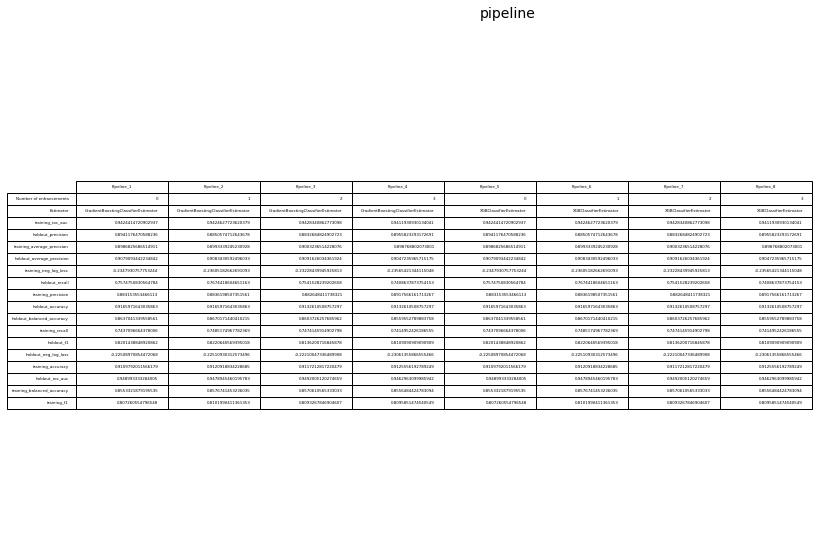

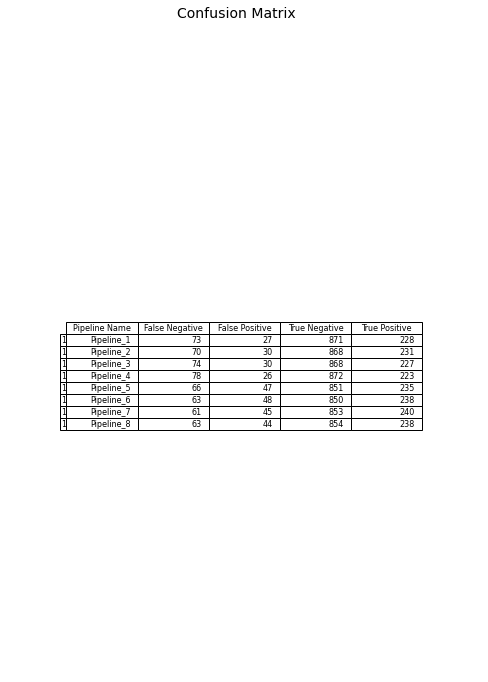

In [47]:
# Save the pipeline values and confusion matrix values in a pdf file
pp = PdfPages('/project_data/data_asset/Airline_AutoAI_report.pdf')
fn_print_pdf(pipelines.transpose(), pp, "pipeline", 11, 8.5, 'center right', 0.05, 25, 0.10)
fn_print_pdf(confusion_matrix, pp, "Confusion Matrix", 8.5, 11, 'center', 0.05, 11, 0.25)

## Feature Importance for each pipeline


 
 Pipeline_1

Phase:  pre_hpo_d_output


,features_importance
DEPARTURE_DELAY,0.833333
TAXI_OUT,0.125000
DISTANCE,0.016667
DAY,0.008333
ORIGIN_AIRPORT,0.008333
DESTINATION_AIRPORT,0.008333
DAY_OF_WEEK,0.000000


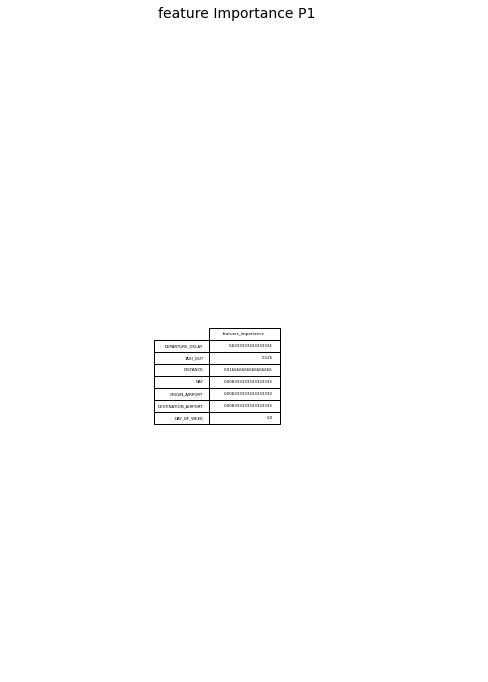


 
 Pipeline_2

Phase:  hpo_d_output


,features_importance
DEPARTURE_DELAY,0.800
TAXI_OUT,0.128
DISTANCE,0.024
DAY,0.016
ORIGIN_AIRPORT,0.016
DESTINATION_AIRPORT,0.016
DAY_OF_WEEK,0.000


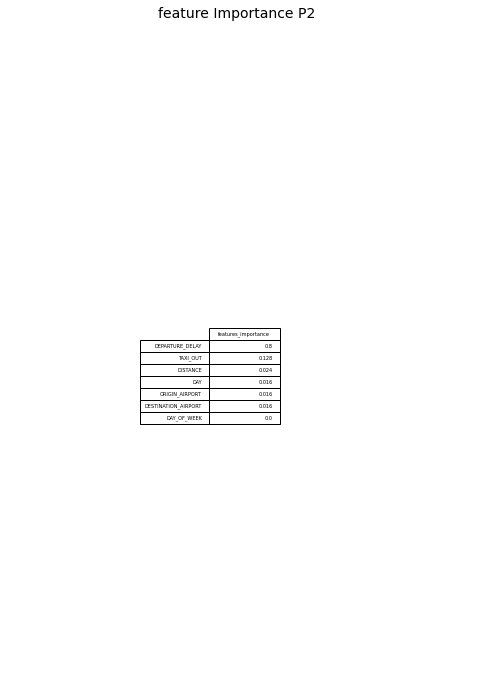


 
 Pipeline_3

Phase:  cognito_output


,features_importance
NewFeature_1_sum(DEPARTURE_DELAY__TAXI_OUT),0.632911
NewFeature_6_sum(sqrt(DEPARTURE_DELAY)__sqrt(TAXI_OUT)),0.278481
DISTANCE,0.025316
NewFeature_4_sum(DEPARTURE_DELAY__sqrt(TAXI_OUT)),0.025316
DAY,0.006329
ORIGIN_AIRPORT,0.006329
NewFeature_2_sum(DEPARTURE_DELAY__sqrt(DESTINATION_AIRPORT)),0.006329
NewFeature_5_sum(sqrt(DAY)__sqrt(DEPARTURE_DELAY)),0.006329
TAXI_OUT,0.006329
DESTINATION_AIRPORT,0.006329


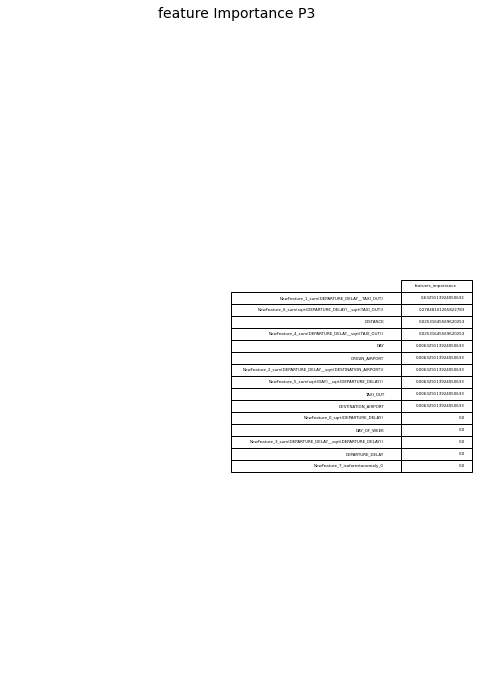


 
 Pipeline_4

Phase:  hpo_c_output


,features_importance
NewFeature_1_sum(DEPARTURE_DELAY__TAXI_OUT),0.699301
NewFeature_6_sum(sqrt(DEPARTURE_DELAY)__sqrt(TAXI_OUT)),0.237762
DISTANCE,0.020979
NewFeature_4_sum(DEPARTURE_DELAY__sqrt(TAXI_OUT)),0.020979
DAY,0.006993
NewFeature_2_sum(DEPARTURE_DELAY__sqrt(DESTINATION_AIRPORT)),0.006993
DESTINATION_AIRPORT,0.006993
NewFeature_0_sqrt(DEPARTURE_DELAY),0.000000
ORIGIN_AIRPORT,0.000000
DAY_OF_WEEK,0.000000


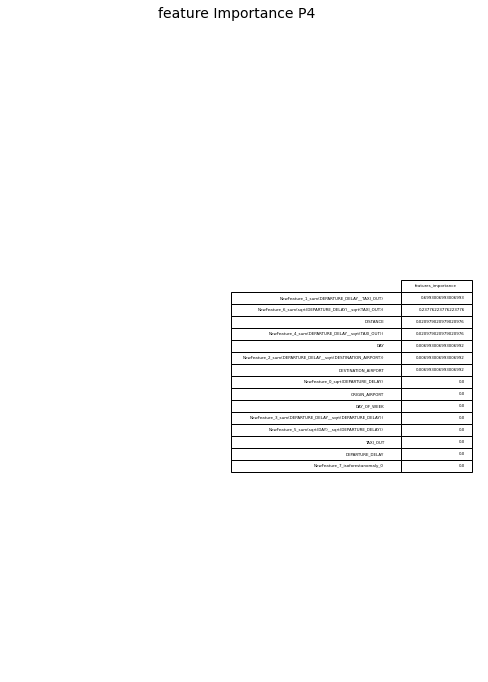


 
 Pipeline_5

Phase:  pre_hpo_d_output


,features_importance
DEPARTURE_DELAY,0.735294
TAXI_OUT,0.183824
DAY,0.022059
DISTANCE,0.022059
DESTINATION_AIRPORT,0.022059
ORIGIN_AIRPORT,0.014706
DAY_OF_WEEK,0.000000


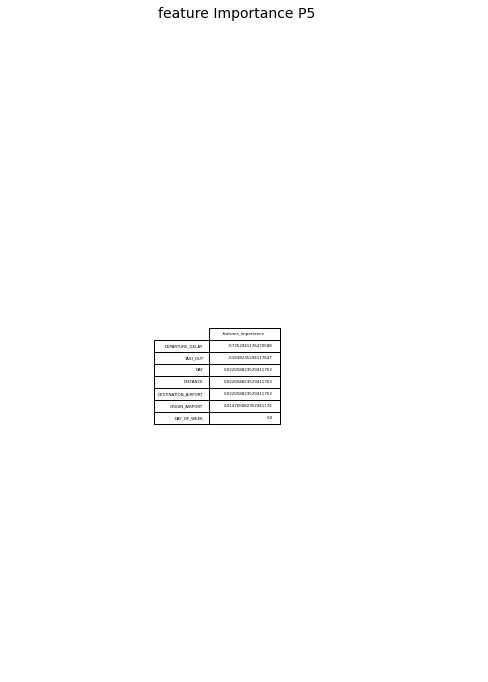


 
 Pipeline_6

Phase:  hpo_d_output


,features_importance
DEPARTURE_DELAY,0.740741
TAXI_OUT,0.177778
DAY,0.022222
DISTANCE,0.022222
DESTINATION_AIRPORT,0.022222
ORIGIN_AIRPORT,0.014815
DAY_OF_WEEK,0.000000


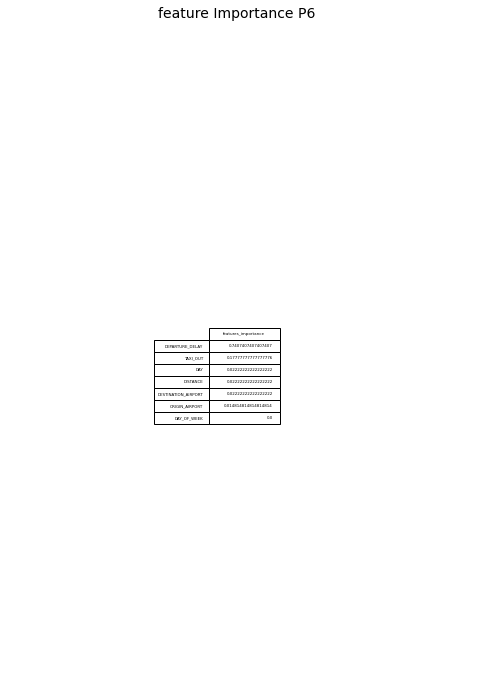


 
 Pipeline_7

Phase:  cognito_output


,features_importance
NewFeature_6_sum(DEPARTURE_DELAY__TAXI_OUT),0.709220
DEPARTURE_DELAY,0.092199
NewFeature_7_sum(DEPARTURE_DELAY__DISTANCE),0.028369
DAY,0.021277
NewFeature_3_sum(ORIGIN_AIRPORT__TAXI_OUT),0.021277
NewFeature_4_sum(DESTINATION_AIRPORT__DEPARTURE_DELAY),0.021277
DISTANCE,0.021277
DESTINATION_AIRPORT,0.021277
ORIGIN_AIRPORT,0.014184
NewFeature_1_sum(DAY__TAXI_OUT),0.014184


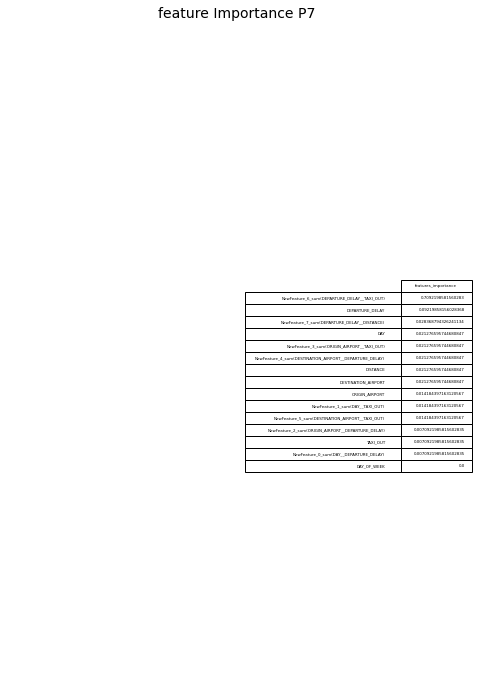


 
 Pipeline_8

Phase:  hpo_c_output


,features_importance
NewFeature_6_sum(DEPARTURE_DELAY__TAXI_OUT),0.877193
DEPARTURE_DELAY,0.043860
DAY,0.008772
NewFeature_3_sum(ORIGIN_AIRPORT__TAXI_OUT),0.008772
ORIGIN_AIRPORT,0.008772
NewFeature_1_sum(DAY__TAXI_OUT),0.008772
NewFeature_5_sum(DESTINATION_AIRPORT__TAXI_OUT),0.008772
NewFeature_4_sum(DESTINATION_AIRPORT__DEPARTURE_DELAY),0.008772
DISTANCE,0.008772
NewFeature_7_sum(DEPARTURE_DELAY__DISTANCE),0.008772


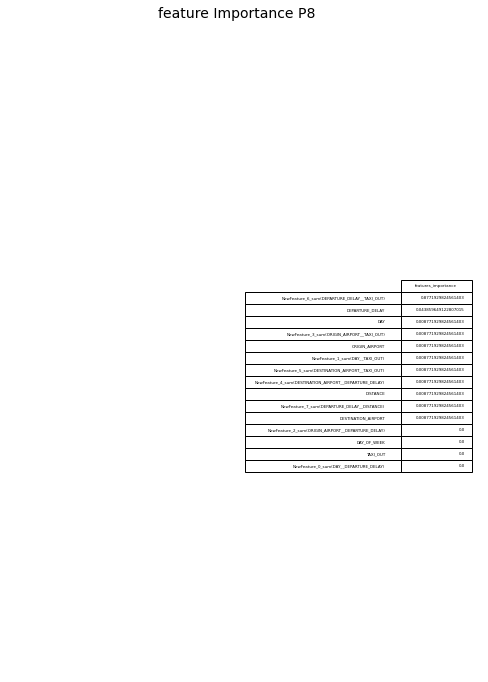

In [48]:
for pdetails in training_details['entity']['status'].get('metrics', []):
    if pdetails['context']['intermediate_model']['name'] == 'P1' or pdetails['context']['intermediate_model']['name'] == 'P5':
        if pdetails['context']['phase'] == 'pre_hpo_d_output':
            data2 = pdetails['context'].get('features_importance', [{'features': {}}])[0]['features']
            columns = [name for name in data2.keys()]
            values = [[value for value in data2.values()]]
            values = np.array(values) / sum(np.array(values[0]))
            
            features_importance_data = DataFrame(data=values, columns=columns, index=['features_importance'])
            features_importance_data = features_importance_data.transpose()
            features_importance_data.sort_values(by='features_importance', ascending=False, inplace=True)
            print("\n \n", f"Pipeline_{pdetails['context']['intermediate_model']['name'].split('P')[-1]}\n" )
            print("Phase: ", pdetails['context']['phase'])
            display(features_importance_data)
            
            # Save the feature importance values to the pdf file
            titletext="feature Importance "+pdetails['context']['intermediate_model']['name']
            fn_print_pdf(features_importance_data, pp, titletext, 8.5, 11, 'center', 0.05, 11, 0.4)
            
    elif  pdetails['context']['intermediate_model']['name'] == 'P2' or pdetails['context']['intermediate_model']['name'] == 'P6':
        if pdetails['context']['phase'] == 'hpo_d_output':
            data2 = pdetails['context'].get('features_importance', [{'features': {}}])[0]['features']
            columns = [name for name in data2.keys()]
            values = [[value for value in data2.values()]]
            values = np.array(values) / sum(np.array(values[0]))

            features_importance_data = DataFrame(data=values, columns=columns, index=['features_importance'])
            features_importance_data = features_importance_data.transpose()
            features_importance_data.sort_values(by='features_importance', ascending=False, inplace=True)
            print("\n \n", f"Pipeline_{pdetails['context']['intermediate_model']['name'].split('P')[-1]}\n" )
            print("Phase: ", pdetails['context']['phase'])
            display(features_importance_data)
            
            # Save the feature importance values to the pdf file
            titletext="feature Importance "+pdetails['context']['intermediate_model']['name']
            fn_print_pdf(features_importance_data, pp, titletext, 8.5, 11, 'center', 0.05, 11, 0.4)
            
            
    elif  pdetails['context']['intermediate_model']['name'] == 'P3' or pdetails['context']['intermediate_model']['name'] == 'P7':
        if pdetails['context']['phase'] == 'cognito_output':
            data2 = pdetails['context'].get('features_importance', [{'features': {}}])[0]['features']
            columns = [name for name in data2.keys()]
            values = [[value for value in data2.values()]]
            values = np.array(values) / sum(np.array(values[0]))
        
            features_importance_data = DataFrame(data=values, columns=columns, index=['features_importance'])
            features_importance_data = features_importance_data.transpose()
            features_importance_data.sort_values(by='features_importance', ascending=False, inplace=True)
            print("\n \n", f"Pipeline_{pdetails['context']['intermediate_model']['name'].split('P')[-1]}\n" )
            print("Phase: ", pdetails['context']['phase'])
            display(features_importance_data)
            
            # Save the feature importance values to the pdf file
            titletext="feature Importance "+pdetails['context']['intermediate_model']['name']
            fn_print_pdf(features_importance_data, pp, titletext, 8.5, 11, 'center right', 0.05, 11, 0.25)
            
    elif  pdetails['context']['intermediate_model']['name'] == 'P4' or pdetails['context']['intermediate_model']['name'] == 'P8':
        if pdetails['context']['phase'] == 'hpo_c_output':
            data2 = pdetails['context'].get('features_importance', [{'features': {}}])[0]['features']
            columns = [name for name in data2.keys()]
            values = [[value for value in data2.values()]]
            values = np.array(values) / sum(np.array(values[0]))
        
            features_importance_data = DataFrame(data=values, columns=columns, index=['features_importance'])
            features_importance_data = features_importance_data.transpose()
            features_importance_data.sort_values(by='features_importance', ascending=False, inplace=True)
            print("\n \n", f"Pipeline_{pdetails['context']['intermediate_model']['name'].split('P')[-1]}\n" )
            print("Phase: ", pdetails['context']['phase'])
            display(features_importance_data) 
            
            # Save the feature importance values to the pdf file
            titletext="feature Importance "+pdetails['context']['intermediate_model']['name']
            fn_print_pdf(features_importance_data, pp, titletext, 8.5, 11, 'center right', 0.05, 11, 0.25)

In [49]:
pp.close()

In [19]:
# END